In [167]:
# Imports used in model
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gp
import time
import linecache
import rasterio
import pandas as pd
# Places matplot library inline
%matplotlib inline

In [168]:
# Read in temperature at gage locations
temp_data = np.genfromtxt(r'C:\Users\m2echjmh\Desktop\Evap_CURG\IDWM\temp.csv', delimiter=None, skip_header=0, skip_footer=0, converters=None, filling_values= -9999)
# temp_data

In [169]:
# Read in shapefile containing x,y coordinates of gage locations
gage_loc = gp.GeoDataFrame.from_file(r'C:\Users\m2echjmh\Desktop\Evap_CURG\IDWM\Gage.shp')
# gage_loc.plot()
gage_loc_np = gage_loc.as_matrix(['POINT_X','POINT_Y'])
# gage_loc_np

In [170]:
# Code developed and can be used at a later date for sizing & understanding grids
'''
# Load a precipitation ascii grid as template 
precip_array_np = np.loadtxt(r'C:\Users\m2echjmh\Desktop\Evap_CURG\IDWM\1HR_2013Oct31_0100.tin.asc', skiprows=6)

# Load header of ascii grid as template
x=1
header_list = []
while x < 7:
    header_list.append(linecache.getline(r'C:\Users\m2echjmh\Desktop\Evap_CURG\IDWM\1HR_2013Oct31_0100.tin.asc', x))
    x+=1
header_tuple = tuple(header_list)
#header_tuple

#Mask every position where there is a -9999:
masked_data = np.ma.masked_equal(precip_array_np, -9999)

#Plot the matrix:
#fig = plt.figure()
ax = fig.gca()
colmap = plt.get_cmap('gist_ncar') 
ax.matshow(masked_data, cmap=colmap) #_r => reverse the standard color map
#plt.tight_layout()
#plt.savefig("rainfall_griddata.png", format="png", bbox_inches='tight', transparent=True, dpi=300)
#plt.show()

'''

'\n# Load a precipitation ascii grid as template \nprecip_array_np = np.loadtxt(r\'C:\\Users\\m2echjmh\\Desktop\\Evap_CURG\\IDWM\x01HR_2013Oct31_0100.tin.asc\', skiprows=6)\n\n# Load header of ascii grid as template\nx=1\nheader_list = []\nwhile x < 7:\n    header_list.append(linecache.getline(r\'C:\\Users\\m2echjmh\\Desktop\\Evap_CURG\\IDWM\x01HR_2013Oct31_0100.tin.asc\', x))\n    x+=1\nheader_tuple = tuple(header_list)\n#header_tuple\n\n#Mask every position where there is a -9999:\nmasked_data = np.ma.masked_equal(precip_array_np, -9999)\n\n#Plot the matrix:\n#fig = plt.figure()\nax = fig.gca()\ncolmap = plt.get_cmap(\'gist_ncar\') \nax.matshow(masked_data, cmap=colmap) #_r => reverse the standard color map\n#plt.tight_layout()\n#plt.savefig("rainfall_griddata.png", format="png", bbox_inches=\'tight\', transparent=True, dpi=300)\n#plt.show()\n\n'

In [171]:
# Code to create a coordinate array of grid cell centriods starting at lower left and working to upper right 
'''
start = time.time()
i = -796
j = 76
counter = 0
coor = np.zeros((860475,2))
while j < 901:
    while i < 247:
        coor[counter]= i,j
        i += 1
        counter += 1
    j += 1
    i = -796
end = time.time()
print end - start
np.save('coor', coor)
'''
coor_np = np.load(file='coor.npy')

In [172]:
# Load raster tiff generated in arcgis that is projected in correct coordinate system
with rasterio.open(r'C:\Users\m2echjmh\Desktop\Evap_CURG\IDWM\basin_raster4.tif', 'r+') as r:
    basin = r.read()  # read all raster values
    print(basin.shape)  # this is a numpy array, with dimensions [band, row, col]
    r.write(basin)

(1L, 825L, 1043L)


In [173]:
# resize array back to 2D
basin_np = np.squeeze(basin)

In [174]:
#Function for calculating Euclidian distance
def Eucl_Dis(gage, coor):
    D = np.sqrt(((gage-coor)**2)[0]+((gage-coor)**2)[1])
    return D

In [175]:
# Bring in lat long of polygons
import geopandas as gp
subbasin = gp.GeoDataFrame.from_file(
    'C:\Users\m2echjmh\Desktop\Evap_CURG\Trinity_Subbasins\Subbasin265.shp')
subbasin_lat=subbasin.as_matrix(['Lat','Long'])

In [176]:
# Code to create a array of distances to gages for every x,y coordinate in grid cell
# Code takes around 26 minutes for 50 gages
'''
j= 0
i= 0
jmax=len(D)
imax=D.size/len(D)
start = time.time()
while j < jmax:
    while i < imax:
        D[j][i] = Eucl_Dis(np_gage[i], np_coor[j])
        i +=1
    j += 1
    i = 0
end = time.time()
np.save('D_matrix', D)
end-start
'''
distance_data = np.load(file='D_matrix.npy')

In [177]:
# Hamon Equation
def Hamon(J, T_a, phi):
    return 0.55*(((24.0/3.14)*(np.arccos(-1.0*np.tan(np.deg2rad(phi))*np.tan(0.4093*np.sin((((2.0*np.pi)/365.0)*J)-1.405))))/12)**2)*(2166.74*((0.6108*np.exp((17.27*((T_a-32.0)*(5.0/9.0)))/(237.3+(T_a-32.0)*(5.0/9.0))))/((T_a-32.0)*(5.0/9.0)+273.15))/100)

In [178]:
def IDWF(ID_array,Value_column):
    array = np.sum(ID_array*Value_column,axis=1)/np.sum(ID_array,axis=1)
    return array

In [179]:
# Read in temperature at gage locations
temp_data = pd.read_csv(r'C:\Users\m2echjmh\Desktop\Evap_CURG\IDWM\temp_complete.csv', sep='\s+', delimiter=',',header=0, names=None, index_col=None, usecols=None, squeeze=False, prefix=None, mangle_dupe_cols=True, dtype=None, engine=None, converters=None, true_values=None, false_values=None, skipinitialspace=True, skiprows=6, na_values=None, keep_default_na=True, na_filter=True, verbose=False, skip_blank_lines=True, parse_dates=False, infer_datetime_format=True, keep_date_col=True, date_parser=None, dayfirst=False, iterator=False, chunksize=None, compression='infer', thousands=None, decimal='.', lineterminator=None, quotechar='"', quoting=0, escapechar=None, comment=None, encoding=None, dialect=None, tupleize_cols=False, error_bad_lines=True, warn_bad_lines=True, skipfooter=0, skip_footer=0, doublequote=True, delim_whitespace=False, as_recarray=False, compact_ints=False, use_unsigned=False, low_memory=True, buffer_lines=None, memory_map=False, float_precision=None)
temp_data['Time'] = pd.to_datetime(temp_data['Time'])

2

In [180]:
temp_data_np = np.array(temp_data.fillna(value=-9999))[:,1:]
temp_np = temp_data_np[0]
miss_np = np.where(temp_np<0)
miss_np

(array([ 0,  5,  6,  7,  8, 12, 13, 16, 19, 21, 22, 23, 24, 26, 27, 28, 30,
        32, 34, 35, 36, 41, 43, 44, 47, 48, 50], dtype=int64),)

In [181]:
# Code to determine which gages have missing data and to exclude data from the calculation matrix
temp_np = np.delete(temp_data_np[0], miss_np, 0)
print temp_np
dist_np = np.delete(distance_data, miss_np, 1)
dist_np.shape

[55.5 54.5 44.5 55.0 55.0 45.0 59.0 46.5 41.0 43.5 42.0 67.0 44.5 40.5 55.0
 44.0 60.0 67.5 39.0 43.5 58.0 64.0 54.0 69.0]


(860475L, 24L)

In [182]:
# code to create an inverse distance array can be changed to develop 1/D^2 and 1/1/D^3
inver_dist_np = 1.0/dist_np

In [183]:
# Generate inverse distance weighted temperature for all coordinates
IDW_array=IDWF(inver_dist_np,temp_np)

In [184]:
#IDW temperature grid creation
start = time.time()
i = 824
j = 0
counter = 0
IDWtemp_np = np.zeros((825, 1043))
while i > -1 :
    while j < 1043:
        IDWtemp_np[i, j]=IDW_array[counter]
        #print i,j
        #print counter
        j += 1
        counter += 1
    i -= 1
    j = 0
end = time.time()
print end - start

0.580000162125


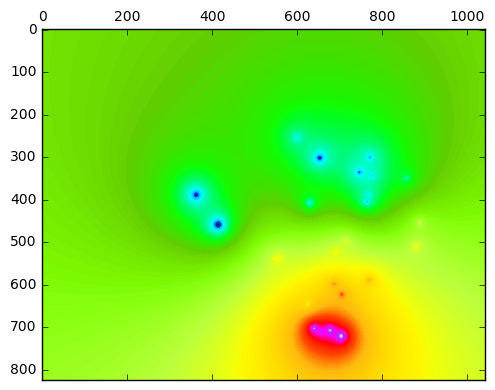

In [185]:
# Plot the IDW temp matrix:

fig = plt.figure()
ax = fig.gca()
colmap = plt.get_cmap('gist_ncar') 
ax.matshow(IDWtemp_np, cmap=colmap) #_r => reverse the standard color map
plt.tight_layout()
#plt.savefig("rainfall_griddata.png", format="png", bbox_inches='tight', transparent=False, dpi=300)
plt.show()


In [186]:
subbasin_temp = np.zeros((288,2))
i = 0
while i < 288:
    subbasin_temp[i]=i, np.ma.mean(np.ma.masked_where(np.ma.getmask(np.ma.masked_where(basin_np != i, basin_np)), IDWtemp_np))
    i += 1

In [191]:
evap = np.zeros((288,2))
i = 0
J = 12
while i < 288:
    evap[i] = i, Hamon(temp_data.loc[0,'Time'].to_datetime().timetuple().tm_yday,subbasin_temp[i,1],subbasin_lat[i,0])
    i += 1

In [192]:
evap

array([[  0.00000000e+00,   3.03828129e-02],
       [  1.00000000e+00,   3.13205671e-02],
       [  2.00000000e+00,   2.95550925e-02],
       [  3.00000000e+00,   2.84809102e-02],
       [  4.00000000e+00,   3.12062887e-02],
       [  5.00000000e+00,   3.21007860e-02],
       [  6.00000000e+00,   3.16936472e-02],
       [  7.00000000e+00,   3.15892439e-02],
       [  8.00000000e+00,   3.31137745e-02],
       [  9.00000000e+00,   3.40237973e-02],
       [  1.00000000e+01,   3.54697575e-02],
       [  1.10000000e+01,   3.53227862e-02],
       [  1.20000000e+01,   3.59647442e-02],
       [  1.30000000e+01,   3.62118573e-02],
       [  1.40000000e+01,   3.73086359e-02],
       [  1.50000000e+01,   3.69021811e-02],
       [  1.60000000e+01,   3.81658067e-02],
       [  1.70000000e+01,   3.77294782e-02],
       [  1.80000000e+01,   4.08751779e-02],
       [  1.90000000e+01,   3.17334706e-02],
       [  2.00000000e+01,   3.15070082e-02],
       [  2.10000000e+01,   3.14363738e-02],
       [  